In [32]:
%matplotlib inline
import pandas as pd, datetime as dt
import collections
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import glob, os

### Input CO2 T-A and fuel type

In [33]:
TA = 112  # g/km, the type-approval for this vehicle

fuel_type = str('diesel')

In [34]:
if fuel_type == 'diesel':
    NOx_lim = 80 # mg/km
    print(NOx_lim)
elif fuel_type == 'gasoline':
    NOx_lim = 60 # mg/km
    print(NOx_lim)
else:
    print('enter valid fuel type')

80


## NOx vs CO2

In [35]:
files_lab = glob.glob('*C.xls')                                                   # read all VELA2 files
dic_lab = {}                                                                     # empty dictionary lab tests
                                                                    
i = 1
for each in files_lab:
    
    %time df = pd.read_excel(each, sheetname=1, header=0)                          # read the proper sheets within each file
  
    CO2 = df['c_CO2_Dil_g_vec\n[grams]']
    CO2_sum = CO2.sum()
    NOx = df['c_NOx_Dil_g_vec\n[grams]']
    NOx_sum = NOx.sum()
    
    v = df['DACtrl_ActualSpeed\n[kph]']            #group speed by intervals
    t_s = len(df.index)                                                #  time(s)
    t_h = t_s/3600                                                                    # time (hours)
    v_mean = v.mean()                                                  # speed means
    d = v_mean * t_h #b.reset_index(drop=True) * d.reset_index(drop=True)                # distance means
    
    CO2km = CO2_sum/d                                                    # CO2 per km 
    #CO2pct = CO2km*100/CO2_TA                                            # emissions as % of type approval (98 g/km)
    NOxkm = NOx_sum/d                                                    # NOx / km
    
    key = each.split('al_')[1].split('.x')[0]                             # shortening the titles of the files
    
    key = str(i) + "." + str(key)                                        # numbering the files
    dic_lab[key] = [CO2km , NOxkm, d, t_s]                                         # save means in the dictionary
    i = i+1

Wall time: 854 ms
Wall time: 483 ms
Wall time: 505 ms
Wall time: 743 ms
Wall time: 500 ms
Wall time: 484 ms
Wall time: 461 ms
Wall time: 521 ms
Wall time: 462 ms
Wall time: 506 ms
Wall time: 464 ms
Wall time: 476 ms
Wall time: 465 ms
Wall time: 776 ms
Wall time: 698 ms
Wall time: 695 ms


In [36]:
files_road = glob.glob('*[0-9].xlsx')                                         # read all EMROAD files
dic_road = {}                                                            # empty dictionary road test

i = 1
for each in files_road:
    
    %time df = pd.read_excel(each, sheetname='TEST REPORT', header=6)

    df.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)   # convert the headers to read them: ' ' for '_'
    df.rename(columns=lambda x: x.strip().replace(".", "_"), inplace=True)   # convert the headers to read them: '.' for '_'
    
    
    CO2_COMP = df.COMPLETE_TEST['CO2'][1]      # g/km
    #CO2_COMP = CO2_COMP_*100/CO2_TA             # %
    CO2_URB = df.URBAN['CO2'][1]               # g/km
    #CO2_URB = CO2_URB_*100/CO2_TA               # %
    CO2_RUR = df.RURAL['CO2'][1]               # g/km
    #CO2_RUR = CO2_RUR_*100/CO2_TA               # %
    CO2_MOT = df.MOTORW_['CO2'][1]             # g/km
    #CO2_MOT = CO2_MOT_*100/CO2_TA               # %
    #CO2 = [CO2_COMP,CO2_URB,CO2_RUR,CO2_MOT]
    
    NOx_COMP = df.COMPLETE_TEST['NOx'][1]
    NOx_URB = df.URBAN['NOx'][1]
    NOx_RUR = df.RURAL['NOx'][1]
    NOx_MOT = df.MOTORW_['NOx'][1]

    #NOx = [NOx_COMP,NOx_URB,NOx_RUR,NOx_MOT]
    
    key = each.split('009_')[1].split('_E')[0]
    each = str(i) + "_" + str(each)
    dic_road[each] = [CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT]     # save means in the dictionary
    i = i+1

Wall time: 17.3 s
Wall time: 17.2 s
Wall time: 17 s
Wall time: 17 s
Wall time: 19.7 s
Wall time: 21.4 s
Wall time: 17.3 s
Wall time: 20.7 s
Wall time: 22.5 s
Wall time: 16.5 s


In [38]:
lab = pd.DataFrame()                                                          
lab = lab.from_dict(dic_lab, orient='index')                                  # convert dic to dataframe
lab['ind2'] = ['1','5','6','3','3','4','4','6','5',
               '2','5','1','5','7','7','8']                                       # proper order
lab.columns = ['CO2_lab','NOx_lab','d','t_s','ind2']                          # headers
lab['NOx_lab'] = lab['NOx_lab']*1000                                          # change unit to mg/km

In [39]:
lab = lab.sort_values('ind2')

lab['test'] = ['N_CD_23','N_CD_23','N+10%_CD_23',
               'N_CD_30','N_CD_30','N_CD_10','N_CD_10','N_HT_23',
               'N_HT_23','N_HT_23','N_HT_23','N_HT_AC18+L_23','N_HT_AC18+L_23',
               'W_CD_23','W_CD_23','W_HT_23']

lab.columns = ['CO2_lab','NOx_lab','d','t_s','ind2','test']
lab

,CO2_lab,NOx_lab,d,t_s,ind2,test
1.NEDC_COLD_FWD-sync_23°C,117.166484,13.481327,10.977814,1181,1,N_CD_23
12.NEDC COLD_FWD-sync_23°C,115.906672,13.658203,10.934522,1181,1,N_CD_23
10.NEDC+10% di Velocita'_COLD_FWD-sync_23°C,125.786075,25.790549,11.945110,1181,2,N+10%_CD_23
4.NEDC_COLD_FWD-sync_30°C,117.265075,15.319817,11.025267,1181,3,N_CD_30
5.NEDC_COLD_FWD-sync_30°C,116.922541,12.930837,11.027169,1181,3,N_CD_30
6.NEDC_COLD_FWD-sync_10°C,124.839999,32.618021,10.976285,1181,4,N_CD_10
7.NEDC_COLD_FWD-sync_10°C,125.405196,33.799508,10.967750,1181,4,N_CD_10
2.NEDC_HOT_FWD-sync_23°C,111.918038,8.570250,10.989402,1181,5,N_HT_23
9.NEDC_HOT_FWD-sync_23°C,111.500642,5.108862,10.964584,1181,5,N_HT_23
11.NEDC HOT_FWD-sync_23°C,113.888061,15.674991,11.027468,1181,5,N_HT_23


In [40]:
name = lab.groupby(lab.ind2).mean()#.reset_index()#drop = True)
name['test'] = ['N_CD_23','N+10%_CD_23',
               'N_CD_30','N_CD_10','N_HT_23',
               'N_HT_AC18+L_23','W_CD_23','W_HT_23']
                
name.columns = ['CO2_lab','NOx_lab','d','t_s','test']

name

,CO2_lab,NOx_lab,d,t_s,test
ind2,,,,,
1,116.536578,13.569765,10.956168,1181.00,N_CD_23
2,125.786075,25.790549,11.945110,1181.00,N+10%_CD_23
3,117.093808,14.125327,11.026218,1181.00,N_CD_30
4,125.122597,33.208765,10.972017,1181.00,N_CD_10
5,111.060489,14.602113,10.974845,1180.75,N_HT_23
6,159.834002,11.899760,10.953096,1181.00,N_HT_AC18+L_23
7,141.472642,47.709706,23.209201,1801.00,W_CD_23
8,137.300333,33.744423,23.185837,1800.00,W_HT_23


In [41]:
road = pd.DataFrame()                               # convert dic to dataframe
road = road.from_dict(dic_road, orient='index')             # proper order
road['ALPH'] = ['b','c','a','a','d','d','e','f','g','h']              # indexing by letters
road.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT','ALPH']  # headers

road['NOx_COMP']=road['NOx_COMP']*1000                  # change unit to mg/km
road['NOx_URB']=road['NOx_URB']*1000                    # change unit to mg/km
road['NOx_RUR']=road['NOx_RUR']*1000                    # change unit to mg/km
road['NOx_MOT']=road['NOx_MOT']*1000                    # change unit to mg/km

road = road.sort_values('ALPH')
road

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
3_PT009_ESP_2017_07_28_EMROAD_Test2.xlsx,134.060683,483.400868,150.726260,260.347471,106.487568,524.689695,140.928529,774.520183,a
4_PT009_ESP_2017_07_31_EMROAD_Test1.xlsx,140.274795,383.171473,157.659239,166.880383,111.473837,396.100536,151.542976,671.241676,a
1_PT009_ESD_2017_08_02_EMROAD_Test1.xlsx,153.499534,628.024140,168.521829,391.882905,136.158057,678.897397,152.579454,886.361307,b
2_PT009_ESL_2017_08_03_EMROAD_Test1.xlsx,152.690542,530.528122,182.469207,356.377508,116.750837,558.046364,146.715336,769.562026,c
5_PT009_LAB_2017_07_28_EMROAD_Test1.xlsx,140.820061,467.430338,150.069431,332.740575,107.034652,376.793416,162.110920,706.171352,d
6_PT009_LAB_2017_07_31_EMROAD_Test2.xlsx,144.011687,620.165412,151.818107,471.962998,107.987229,514.888546,163.232874,884.246356,d
7_PT009_LAD_2017_08_02_EMROAD_Test2.xlsx,155.216962,938.834873,166.912351,681.898403,131.357753,871.606655,160.477869,1251.623040,e
8_PT009_LAL_2017_08_03_EMROAD_Test2.xlsx,157.296861,994.820523,178.892184,727.044049,122.343339,1054.757429,161.050504,1255.725870,f
9_PT009_MIL_2017_08_01_EMROAD_Test2.xlsx,145.374560,799.119738,157.067364,810.163741,118.009277,615.453241,145.044314,836.630839,g
10_PT009_SAC_2017_08_01_EMROAD_Test1.xlsx,155.125804,405.183097,155.209973,405.393182,1.390188,21.460377,NaN,NaN,h


In [42]:
### Reshape index ### THIS create a problem when we create the plot (legend), but so far it works for what we want
r = road
r.index = r.index.str[8:11]
r

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
ESP,134.060683,483.400868,150.726260,260.347471,106.487568,524.689695,140.928529,774.520183,a
ESP,140.274795,383.171473,157.659239,166.880383,111.473837,396.100536,151.542976,671.241676,a
ESD,153.499534,628.024140,168.521829,391.882905,136.158057,678.897397,152.579454,886.361307,b
ESL,152.690542,530.528122,182.469207,356.377508,116.750837,558.046364,146.715336,769.562026,c
LAB,140.820061,467.430338,150.069431,332.740575,107.034652,376.793416,162.110920,706.171352,d
LAB,144.011687,620.165412,151.818107,471.962998,107.987229,514.888546,163.232874,884.246356,d
LAD,155.216962,938.834873,166.912351,681.898403,131.357753,871.606655,160.477869,1251.623040,e
LAL,157.296861,994.820523,178.892184,727.044049,122.343339,1054.757429,161.050504,1255.725870,f
MIL,145.374560,799.119738,157.067364,810.163741,118.009277,615.453241,145.044314,836.630839,g
_SA,155.125804,405.183097,155.209973,405.393182,1.390188,21.460377,NaN,NaN,h


In [43]:
### Group by index and calculate means ###
r_avg = r.groupby(r.index).mean()#.reset_index()#drop = True)
#r_avg['test'] = ['ESP','LAB','MIL','SAC']
                
r_avg.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT']

r_avg[['CO2_COMP','NOx_COMP']]

,CO2_COMP,NOx_COMP
ESD,153.499534,628.024140
ESL,152.690542,530.528122
ESP,137.167739,433.286170
LAB,142.415874,543.797875
LAD,155.216962,938.834873
LAL,157.296861,994.820523
MIL,145.374560,799.119738
_SA,155.125804,405.183097


In [44]:
road = pd.DataFrame()                               # convert dic to dataframe
road = road.from_dict(dic_road, orient='index')             # proper order
road['ALPH'] = ['b','c','a','a','d','d','e','f','g','h']              # indexing by letters
road.columns = ['CO2_COMP','NOx_COMP','CO2_URB','NOx_URB','CO2_RUR','NOx_RUR','CO2_MOT','NOx_MOT','ALPH']  # headers

road['NOx_COMP']=road['NOx_COMP']*1000                  # change unit to mg/km
road['NOx_URB']=road['NOx_URB']*1000                    # change unit to mg/km
road['NOx_RUR']=road['NOx_RUR']*1000                    # change unit to mg/km
road['NOx_MOT']=road['NOx_MOT']*1000                    # change unit to mg/km

road = road.sort_values('ALPH')
road

,CO2_COMP,NOx_COMP,CO2_URB,NOx_URB,CO2_RUR,NOx_RUR,CO2_MOT,NOx_MOT,ALPH
3_PT009_ESP_2017_07_28_EMROAD_Test2.xlsx,134.060683,483.400868,150.726260,260.347471,106.487568,524.689695,140.928529,774.520183,a
4_PT009_ESP_2017_07_31_EMROAD_Test1.xlsx,140.274795,383.171473,157.659239,166.880383,111.473837,396.100536,151.542976,671.241676,a
1_PT009_ESD_2017_08_02_EMROAD_Test1.xlsx,153.499534,628.024140,168.521829,391.882905,136.158057,678.897397,152.579454,886.361307,b
2_PT009_ESL_2017_08_03_EMROAD_Test1.xlsx,152.690542,530.528122,182.469207,356.377508,116.750837,558.046364,146.715336,769.562026,c
5_PT009_LAB_2017_07_28_EMROAD_Test1.xlsx,140.820061,467.430338,150.069431,332.740575,107.034652,376.793416,162.110920,706.171352,d
6_PT009_LAB_2017_07_31_EMROAD_Test2.xlsx,144.011687,620.165412,151.818107,471.962998,107.987229,514.888546,163.232874,884.246356,d
7_PT009_LAD_2017_08_02_EMROAD_Test2.xlsx,155.216962,938.834873,166.912351,681.898403,131.357753,871.606655,160.477869,1251.623040,e
8_PT009_LAL_2017_08_03_EMROAD_Test2.xlsx,157.296861,994.820523,178.892184,727.044049,122.343339,1054.757429,161.050504,1255.725870,f
9_PT009_MIL_2017_08_01_EMROAD_Test2.xlsx,145.374560,799.119738,157.067364,810.163741,118.009277,615.453241,145.044314,836.630839,g
10_PT009_SAC_2017_08_01_EMROAD_Test1.xlsx,155.125804,405.183097,155.209973,405.393182,1.390188,21.460377,NaN,NaN,h


## Plot all tests

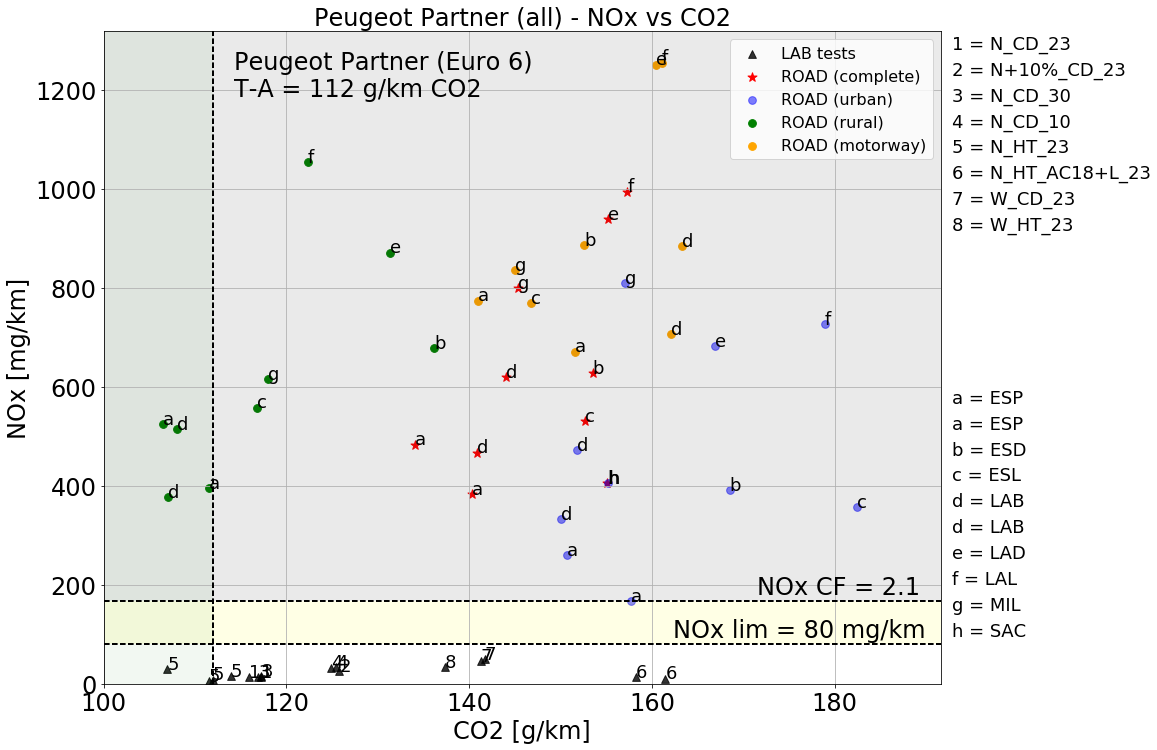

In [45]:
ax = lab.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = 'best')


fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Peugeot Partner (all) - NOx vs CO2', fontsize = fontsize)

lim_inf_CO2 = min(lab.CO2_lab.min(),road.CO2_COMP.min(), road.CO2_URB.min(),
                 road.CO2_RUR.min(),road.CO2_MOT.min()) -0.05*min(lab.CO2_lab.min(),
                road.CO2_COMP.min(), road.CO2_URB.min(), road.CO2_RUR.min(),road.CO2_MOT.min())
lim_sup_CO2 = max(lab.CO2_lab.max(),road.CO2_COMP.max(), road.CO2_URB.max(),
                 road.CO2_RUR.max(),road.CO2_MOT.max()) +0.05*max(lab.CO2_lab.max(),
                road.CO2_COMP.max(), road.CO2_URB.max(), road.CO2_RUR.max(),road.CO2_MOT.max())
lim_inf_NOx = min(lab.NOx_lab.min(),road.NOx_COMP.min(), road.NOx_URB.min(),
                 road.NOx_RUR.min(),road.NOx_MOT.min()) -0.05*min(lab.NOx_lab.min(),
                road.NOx_COMP.min(), road.NOx_URB.min(), road.NOx_RUR.min(),road.NOx_MOT.min())
lim_sup_NOx = max(lab.NOx_lab.max(),road.NOx_COMP.max(), road.NOx_URB.max(),
                 road.NOx_RUR.max(),road.NOx_MOT.max()) +0.05*max(lab.NOx_lab.max(),
                road.NOx_COMP.max(), road.NOx_URB.max(), road.NOx_RUR.max(),road.NOx_MOT.max())

###
lim_inf_CO2 = 100
###

plt.axis([lim_inf_CO2,lim_sup_CO2,0,lim_sup_NOx])                         

if len(name)<10:
    for i, txt in enumerate(lab.ind2):
        ax.annotate(txt, (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
else:
    for i, txt in enumerate(lab.ind2):
        if i<[i for i,x in enumerate(lab.ind2) if x == '10'][0]:
            ax.annotate(txt.split('0')[1], (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18)#, rotation = 30)
        else:
            ax.annotate(txt, (lab.CO2_lab.iat[i],lab.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True)#, rotation = 30)
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.89 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('009_')[1].split('_2017')[0] , fontsize=18)
    i = i+1
    
if TA>lim_inf_CO2:
    ax.annotate('Peugeot Partner (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (TA+0.02*TA, lim_sup_NOx-0.1*lim_sup_NOx), textcoords='data', fontsize=24, clip_on=True)
else:
    ax.annotate('Peugeot Partner (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',
                (lim_inf_CO2+0.02*lim_inf_CO2, lim_sup_NOx-0.1*lim_sup_NOx), textcoords='data', fontsize=24, clip_on=True)
    
ax.annotate('NOx CF = 2.1',(lim_sup_CO2 - 0.22*(lim_sup_CO2-lim_inf_CO2), NOx_lim*2.1 + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx lim = ' + str(NOx_lim) + ' mg/km',(lim_sup_CO2 - 0.32*(lim_sup_CO2-lim_inf_CO2), NOx_lim + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)

plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(NOx_lim, NOx_lim*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_lim*2.1, lim_sup_NOx, facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)

## Plot avg of repeated tests

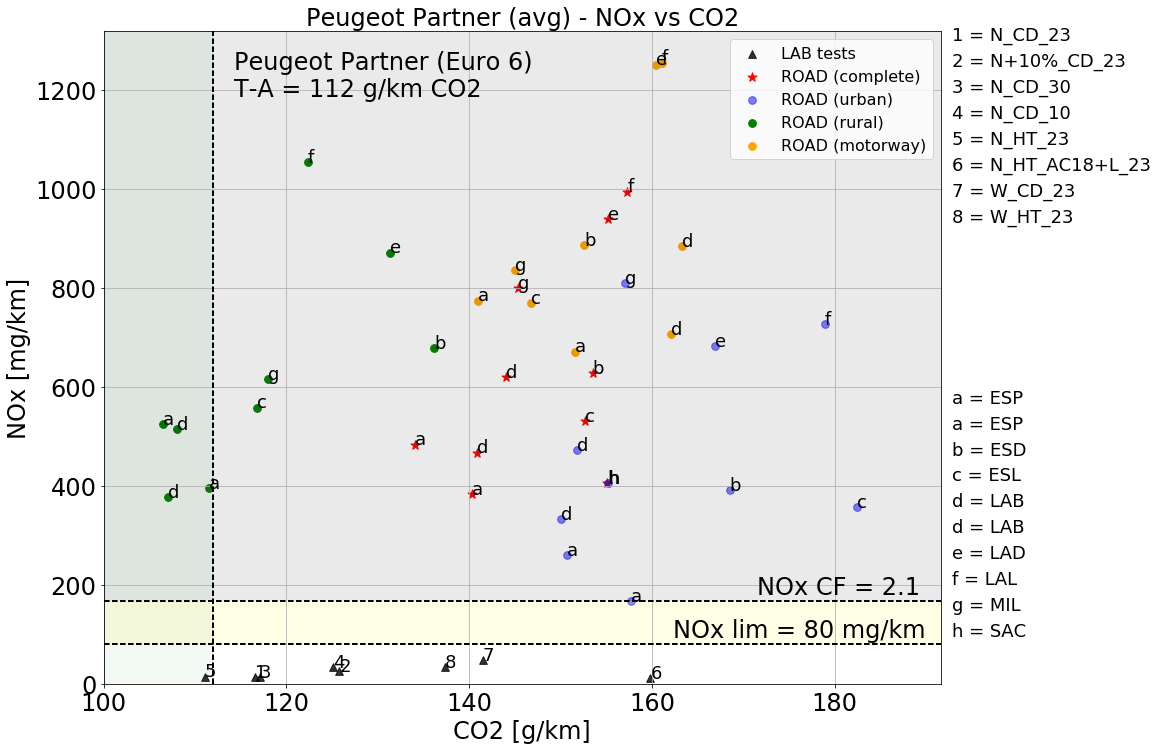

In [46]:
ax = name.plot.scatter('CO2_lab', 'NOx_lab',marker='^', alpha=.8 ,s = 60, c = 'black', 
                      figsize = (15,12), grid ='on')
#plt.legend(lab.index, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for ea in road.index:
road.plot.scatter('CO2_COMP','NOx_COMP', ax=ax, marker='*', s = 90, c = 'red', grid = 'on')
road.plot.scatter('CO2_URB','NOx_URB', ax=ax, s = 60, alpha=.5, c = 'blue', grid = 'on')
road.plot.scatter('CO2_RUR','NOx_RUR', ax=ax, s = 60, c = 'green', grid = 'on')
road.plot.scatter('CO2_MOT','NOx_MOT', ax=ax, s = 60, c = 'orange', grid = 'on')

legend = ('LAB tests','ROAD (complete)','ROAD (urban)','ROAD (rural)','ROAD (motorway)')
plt.legend(legend, fontsize = 16, loc = 'best')

fontsize = 24
plt.ylabel('NOx [mg/km]', fontsize = fontsize)
plt.xlabel('CO2 [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Peugeot Partner (avg) - NOx vs CO2', fontsize = fontsize)

lim_inf_CO2 = min(name.CO2_lab.min(),road.CO2_COMP.min(), road.CO2_URB.min(),
                 road.CO2_RUR.min(),road.CO2_MOT.min()) -0.05*min(name.CO2_lab.min(),
                road.CO2_COMP.min(), road.CO2_URB.min(), road.CO2_RUR.min(),road.CO2_MOT.min())
lim_sup_CO2 = max(name.CO2_lab.max(),road.CO2_COMP.max(), road.CO2_URB.max(),
                 road.CO2_RUR.max(),road.CO2_MOT.max()) +0.05*max(name.CO2_lab.max(),
                road.CO2_COMP.max(), road.CO2_URB.max(), road.CO2_RUR.max(),road.CO2_MOT.max())
lim_inf_NOx = min(name.NOx_lab.min(),road.NOx_COMP.min(), road.NOx_URB.min(),
                 road.NOx_RUR.min(),road.NOx_MOT.min()) -0.05*min(name.NOx_lab.min(),
                road.NOx_COMP.min(), road.NOx_URB.min(), road.NOx_RUR.min(),road.NOx_MOT.min())
lim_sup_NOx = max(name.NOx_lab.max(),road.NOx_COMP.max(), road.NOx_URB.max(),
                 road.NOx_RUR.max(),road.NOx_MOT.max()) +0.05*max(name.NOx_lab.max(),
                road.NOx_COMP.max(), road.NOx_URB.max(), road.NOx_RUR.max(),road.NOx_MOT.max())

###
lim_inf_CO2 = 100
###

plt.axis([lim_inf_CO2,lim_sup_CO2,0,lim_sup_NOx])                             


for i, txt in enumerate(name.test):
    ax.annotate(i+1, (name.CO2_lab.iat[i],name.NOx_lab.iat[i]), ha = 'left', fontsize = 18, clip_on=True) # change txt to i+1
        
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_COMP.iat[i],road.NOx_COMP.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_URB.iat[i],road.NOx_URB.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_RUR.iat[i],road.NOx_RUR.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
for i, txt in enumerate(road.ALPH):
    ax.annotate(txt + '', (road.CO2_MOT.iat[i],road.NOx_MOT.iat[i]), ha = 'left', fontsize = 18, clip_on=True)
    
i = 1
for each in name.test:
    plt.gcf().text(0.91, 0.9 - 0.03*i, str(i) + ' = ' +  each, fontsize=18)  
    i = i+1

i = 0
for each in road.index:
    plt.gcf().text(0.91, 0.45 - 0.03*i, road.ALPH[i] + ' = ' + each.split('009_')[1].split('_2017')[0] , fontsize=18)
    i = i+1
    
ax.annotate('Peugeot Partner (Euro 6) \nT-A = ' + str(TA) + ' g/km CO2',(TA+0.02*TA, lim_sup_NOx-0.1*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx CF = 2.1',(lim_sup_CO2 - 0.22*(lim_sup_CO2-lim_inf_CO2), NOx_lim*2.1 + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)
ax.annotate('NOx lim = ' + str(NOx_lim) + ' mg/km',(lim_sup_CO2 - 0.32*(lim_sup_CO2-lim_inf_CO2), NOx_lim + 0.01*lim_sup_NOx),
            textcoords='data', fontsize=24, clip_on=True)

plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=NOx_lim*2.1, color='k', linestyle='--', linewidth=2 )
plt.axhspan(NOx_lim, NOx_lim*2.1, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_lim*2.1, lim_sup_NOx, facecolor='0.2', alpha=0.1)
plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)